In [1]:
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
%matplotlib inline

# load and merge data sources

In [23]:
train = pd.read_csv("/home/alex/Downloads/kaggle/competition/train.csv")
test = pd.read_csv("/home/alex/Downloads/kaggle/competition/test.csv")
print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 110093 rows, 3 cols
test.shape = 165141 rows, 2 cols


In [3]:
train.head(2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0,Cash
1,123597908,1,Cash


In [4]:
applications_history = pd.read_csv("/home/alex/Downloads/kaggle/competition/applications_history.csv")

print("applications_history.shape = {} rows, {} cols".format(*applications_history.shape))

applications_history.shape = 1670214 rows, 26 cols


In [5]:
applications_history.head(2)

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,...,NAME_PRODUCT_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,49298709,123595216,NaN,1730.430,17145.0,17145.0,0.0,17145.0,Approved,73,...,XNA,35,12.0,middle,365243.0,42.0,300.0,42.0,37.0,0.0
1,50070639,123431468,Cash,25188.615,607500.0,679671.0,NaN,607500.0,Approved,164,...,x-sell,-1,36.0,low_action,365243.0,134.0,916.0,365243.0,365243.0,1.0


In [6]:
client_profile = pd.read_csv("/home/alex/Downloads/kaggle/competition/client_profile.csv")

print("client_profile.shape = {} rows, {} cols".format(*client_profile.shape))

client_profile.shape = 250000 rows, 24 cols


In [7]:
client_profile.head(2)

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,...,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,...,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0


In [22]:
def merge_datasets(df):
    df = df.merge(applications_history, on="APPLICATION_NUMBER")
    df = df.merge(client_profile, on="APPLICATION_NUMBER")
    return df

In [24]:
train = merge_datasets(train)
train.head(2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE_x,PREV_APPLICATION_NUMBER,NAME_CONTRACT_TYPE_y,AMOUNT_ANNUITY_x,AMT_APPLICATION,AMOUNT_CREDIT_x,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123687442,0,Cash,49915814,NaN,6510.015,71668.80,64500.3,7168.50,71668.80,...,3.0,0.700784,0.645914,0.71657,0.0,0.0,1.0,0.0,0.0,2.0
1,123687442,0,Cash,49713743,NaN,9262.215,72634.14,70758.0,7267.14,72634.14,...,3.0,0.700784,0.645914,0.71657,0.0,0.0,1.0,0.0,0.0,2.0


In [25]:
test = merge_datasets(test)
test.head(2)

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE_x,PREV_APPLICATION_NUMBER,NAME_CONTRACT_TYPE_y,AMOUNT_ANNUITY_x,AMT_APPLICATION,AMOUNT_CREDIT_x,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,NAME_CONTRACT_STATUS,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123724268,Cash,49492051,Credit Card,NaN,0.0,0.0,NaN,NaN,Canceled,...,2.0,NaN,0.628266,NaN,0.0,0.0,0.0,0.0,1.0,4.0
1,123724268,Cash,48519927,Credit Card,22500.0,450000.0,450000.0,NaN,450000.0,Approved,...,2.0,NaN,0.628266,NaN,0.0,0.0,0.0,0.0,1.0,4.0


# eda

In [9]:
train.describe()

,APPLICATION_NUMBER,TARGET,PREV_APPLICATION_NUMBER,AMOUNT_ANNUITY_x,AMT_APPLICATION,AMOUNT_CREDIT_x,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,4.202280e+05,420228.000000,4.202280e+05,326397.000000,4.202280e+05,4.202280e+05,1.943580e+05,3.231200e+05,420228.000000,4.202280e+05,...,420225.000000,183174.000000,419393.000000,337332.000000,363903.000000,363903.000000,363903.000000,363903.000000,363903.000000,363903.000000
mean,1.235773e+08,0.080264,4.919142e+07,16011.519794,1.761100e+05,1.970915e+05,6.733848e+03,2.290511e+05,876.975335,3.348848e+02,...,2.158439,0.501750,0.514203,0.511101,0.006224,0.006996,0.033998,0.264224,0.263697,1.909174
std,8.876395e+04,0.271701,5.326144e+05,14836.789397,2.947319e+05,3.202834e+05,2.178062e+04,3.175806e+05,776.496363,1.081812e+04,...,0.913903,0.209820,0.191007,0.195013,0.085832,0.115567,0.210922,0.893392,0.613024,1.879268
min,1.234233e+08,0.000000,4.826822e+07,0.000000,0.000000e+00,0.000000e+00,-4.500000e-01,0.000000e+00,2.000000,-1.000000e+00,...,1.000000,0.014691,0.000010,0.000527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.235005e+08,0.000000,4.873027e+07,6346.800000,1.871100e+04,2.422800e+04,0.000000e+00,5.107500e+04,280.000000,-1.000000e+00,...,2.000000,0.334202,0.392150,0.370650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.235772e+08,0.000000,4.919287e+07,11250.000000,7.120800e+04,8.083800e+04,1.620000e+03,1.124550e+05,578.000000,3.000000e+00,...,2.000000,0.505019,0.564806,0.537070,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.236540e+08,0.000000,4.965256e+07,20796.660000,1.821510e+05,2.185380e+05,7.771500e+03,2.362500e+05,1288.000000,8.100000e+01,...,3.000000,0.672161,0.664242,0.669057,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.237308e+08,1.000000,5.011360e+07,418058.145000,5.850000e+06,4.509688e+06,2.150100e+06,5.850000e+06,2922.000000,4.000000e+06,...,20.000000,0.951624,0.855000,0.896010,3.000000,9.000000,8.000000,27.000000,8.000000,25.000000


In [26]:
print(train.columns)
print(train.columns.shape)

Index(['APPLICATION_NUMBER', 'TARGET', 'NAME_CONTRACT_TYPE_x',
       'PREV_APPLICATION_NUMBER', 'NAME_CONTRACT_TYPE_y', 'AMOUNT_ANNUITY_x',
       'AMT_APPLICATION', 'AMOUNT_CREDIT_x', 'AMOUNT_PAYMENT',
       'AMOUNT_GOODS_PAYMENT', 'NAME_CONTRACT_STATUS', 'DAYS_DECISION',
       'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE',
       'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO',
       'NAME_PRODUCT_TYPE', 'SELLERPLACE_AREA', 'CNT_PAYMENT',
       'NAME_YIELD_GROUP', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE',
       'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION',
       'NFLAG_INSURED_ON_APPROVAL', 'GENDER', 'CHILDRENS', 'TOTAL_SALARY',
       'AMOUNT_CREDIT_y', 'AMOUNT_ANNUITY_y', 'EDUCATION_LEVEL',
       'FAMILY_STATUS', 'REGION_POPULATION', 'AGE', 'DAYS_ON_LAST_JOB',
       'OWN_CAR_AGE', 'FLAG_PHONE', 'FLAG_EMAIL', 'FAMILY_SIZE',
       'EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2',
       'EXTERNAL_SCORING_RATING_3', 'AMT_R

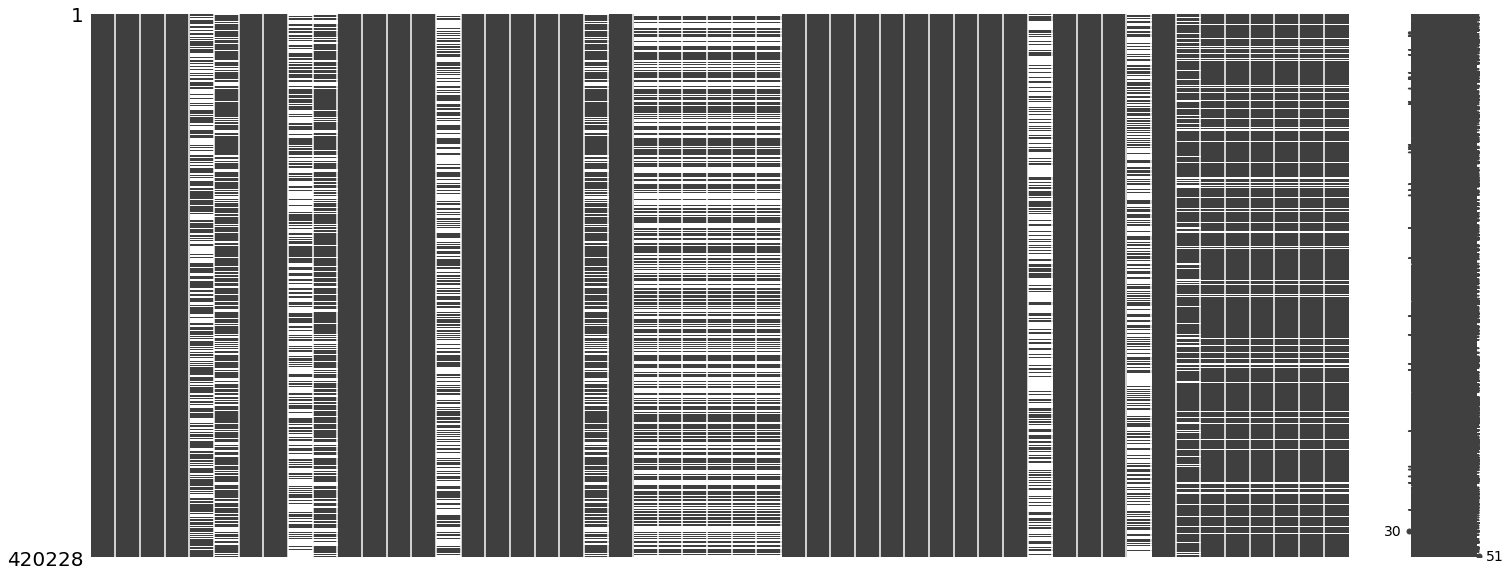

In [10]:
msno.matrix(train)

Данные имеют большое количество пропусков

In [13]:
numerical_features = train.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features.shape[1]}")
numerical_features.head(2)

count of numeric_features 37


,APPLICATION_NUMBER,TARGET,PREV_APPLICATION_NUMBER,AMOUNT_ANNUITY_x,AMT_APPLICATION,AMOUNT_CREDIT_x,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123687442,0,49915814,6510.015,71668.80,64500.3,7168.50,71668.80,240,20,...,3.0,0.700784,0.645914,0.71657,0.0,0.0,1.0,0.0,0.0,2.0
1,123687442,0,49713743,9262.215,72634.14,70758.0,7267.14,72634.14,2702,90,...,3.0,0.700784,0.645914,0.71657,0.0,0.0,1.0,0.0,0.0,2.0


In [15]:
categorical_features = train.select_dtypes(include=[np.object])
print(f"Categorical Feature Count {categorical_features.shape[1]}")
categorical_features.head(2)

Categorical Feature Count 14


,NAME_CONTRACT_TYPE_x,NAME_CONTRACT_TYPE_y,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,NAME_YIELD_GROUP,GENDER,EDUCATION_LEVEL,FAMILY_STATUS
0,Cash,NaN,Approved,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,middle,M,Secondary / secondary special,Married
1,Cash,NaN,Approved,Non-cash from your account,XAP,Family,Repeater,Photo / Cinema Equipment,POS,XNA,high,M,Secondary / secondary special,Married


Данные имеют как числовые так и категориальные фичи. Разберём их подробнее

In [18]:
discrete_feature = [
    feature for feature in numerical_features
    if len(train[feature].unique())<25
]

print(f"Discrete Variables Count: {len(discrete_feature)}")

Discrete Variables Count: 12


In [50]:
continuous_feature = [
    feature for feature in numerical_features
    if feature not in ["TARGET"] + discrete_feature]

print(f"Continuous Feature Count {len(continuous_feature)}")

Continuous Feature Count 25


## целевая переменная

Mean-target: 0.0803


Text(0, 0.5, 'Index')

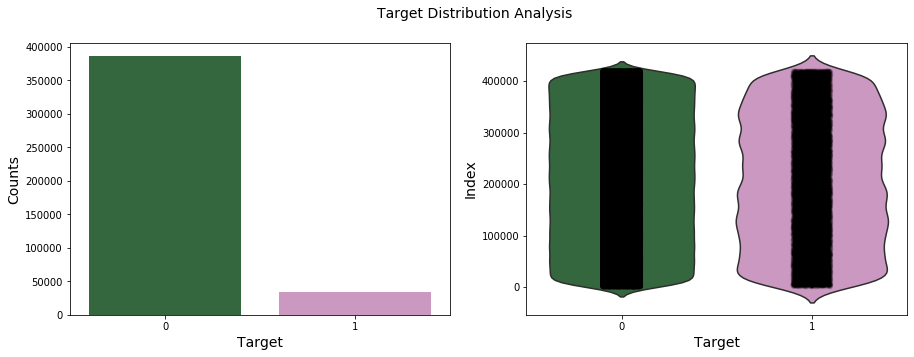

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Target Distribution Analysis", size=14)
print(f"Mean-target: {round(train.TARGET.mean(), 4)}")

sns.countplot(train.TARGET, ax=axes[0], palette="cubehelix")
sns.violinplot(train.TARGET, train.index, ax=axes[1], palette="cubehelix")
sns.stripplot(train.TARGET, train.index, jitter=True, ax=axes[1], color="black", alpha=0.05)

axes[0].set_xlabel("Target", fontsize=14)
axes[0].set_ylabel("Counts", fontsize=14)
axes[1].set_xlabel("Target", fontsize=14)
axes[1].set_ylabel("Index", fontsize=14)

Мы имеем достаточно большой дисбаланс классов, но целевая переменная распределена достаточно равномерно вдоль индексов тренировочного датасета

## распределение признаков

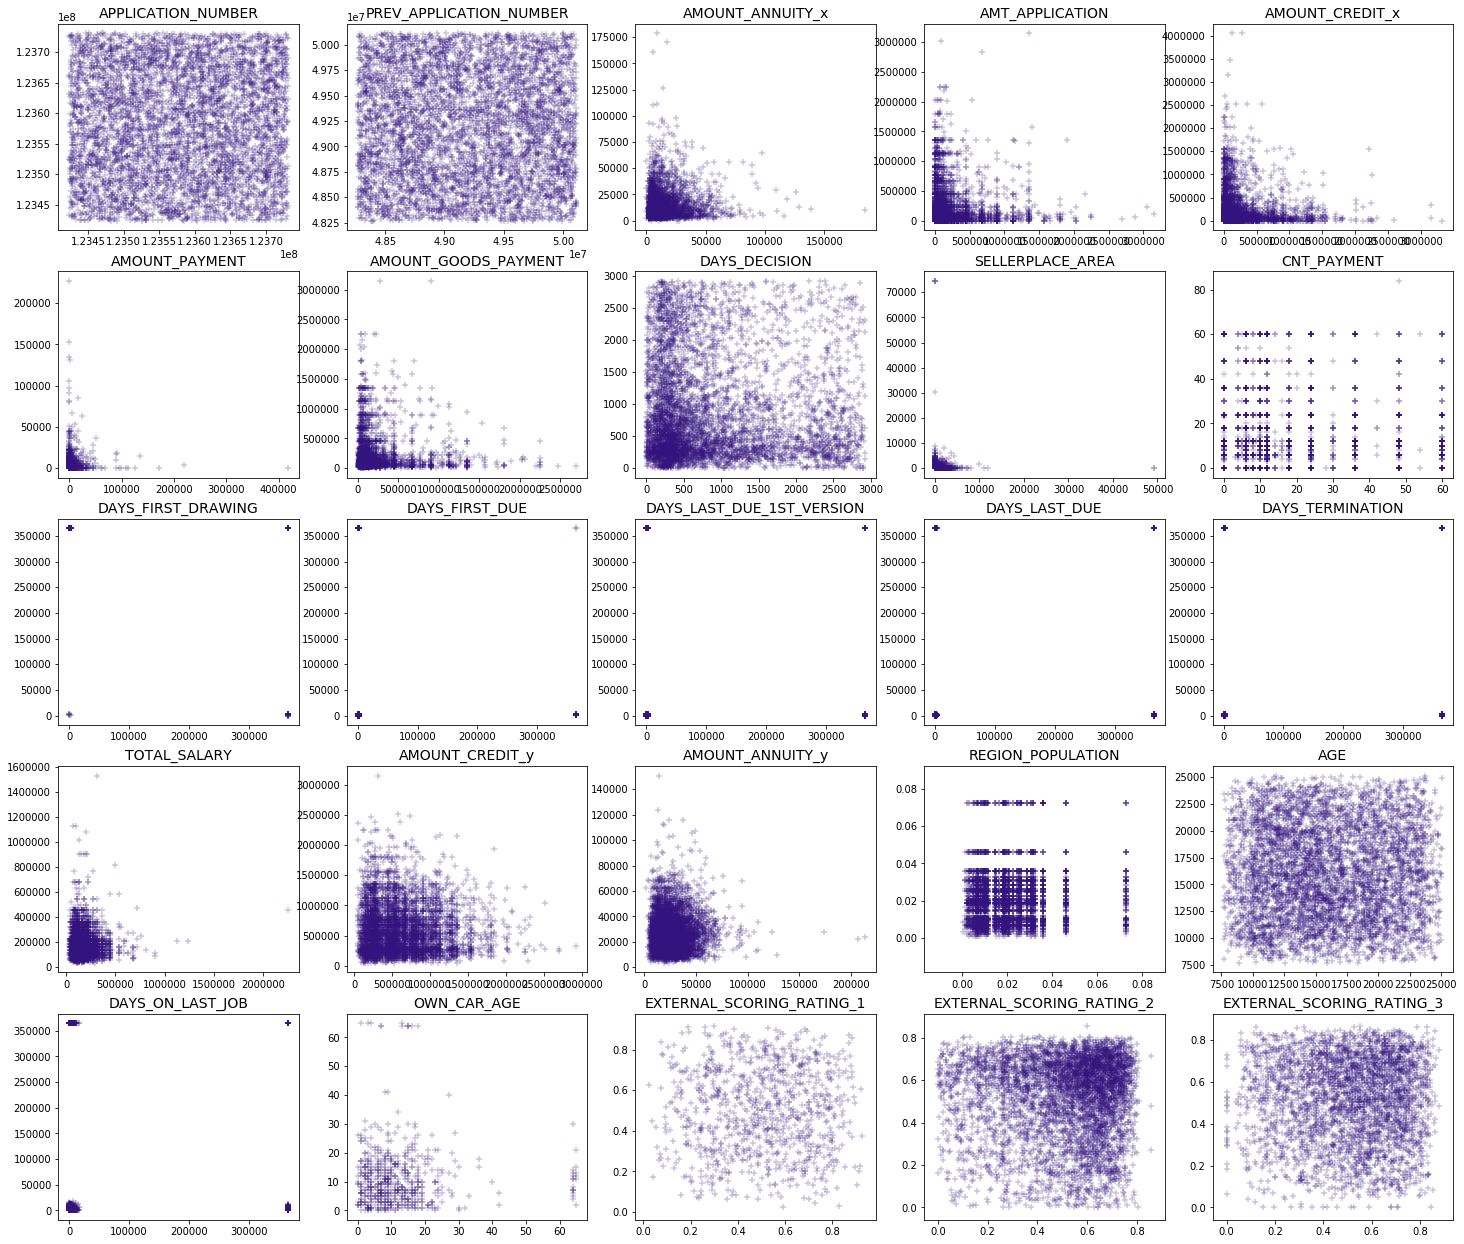

In [69]:
fig, axes = plt.subplots(5, 5, figsize=(25, 22))

for num, feature in enumerate(continuous_feature, start=1):
    plt.subplot(5, 5, num)
    plt.title(f"{feature}", size=14)
    plt.scatter(
        train[feature].sample(5000),
        test[feature].sample(5000),
        color="#33137d",
        alpha=0.25,
        marker="+")

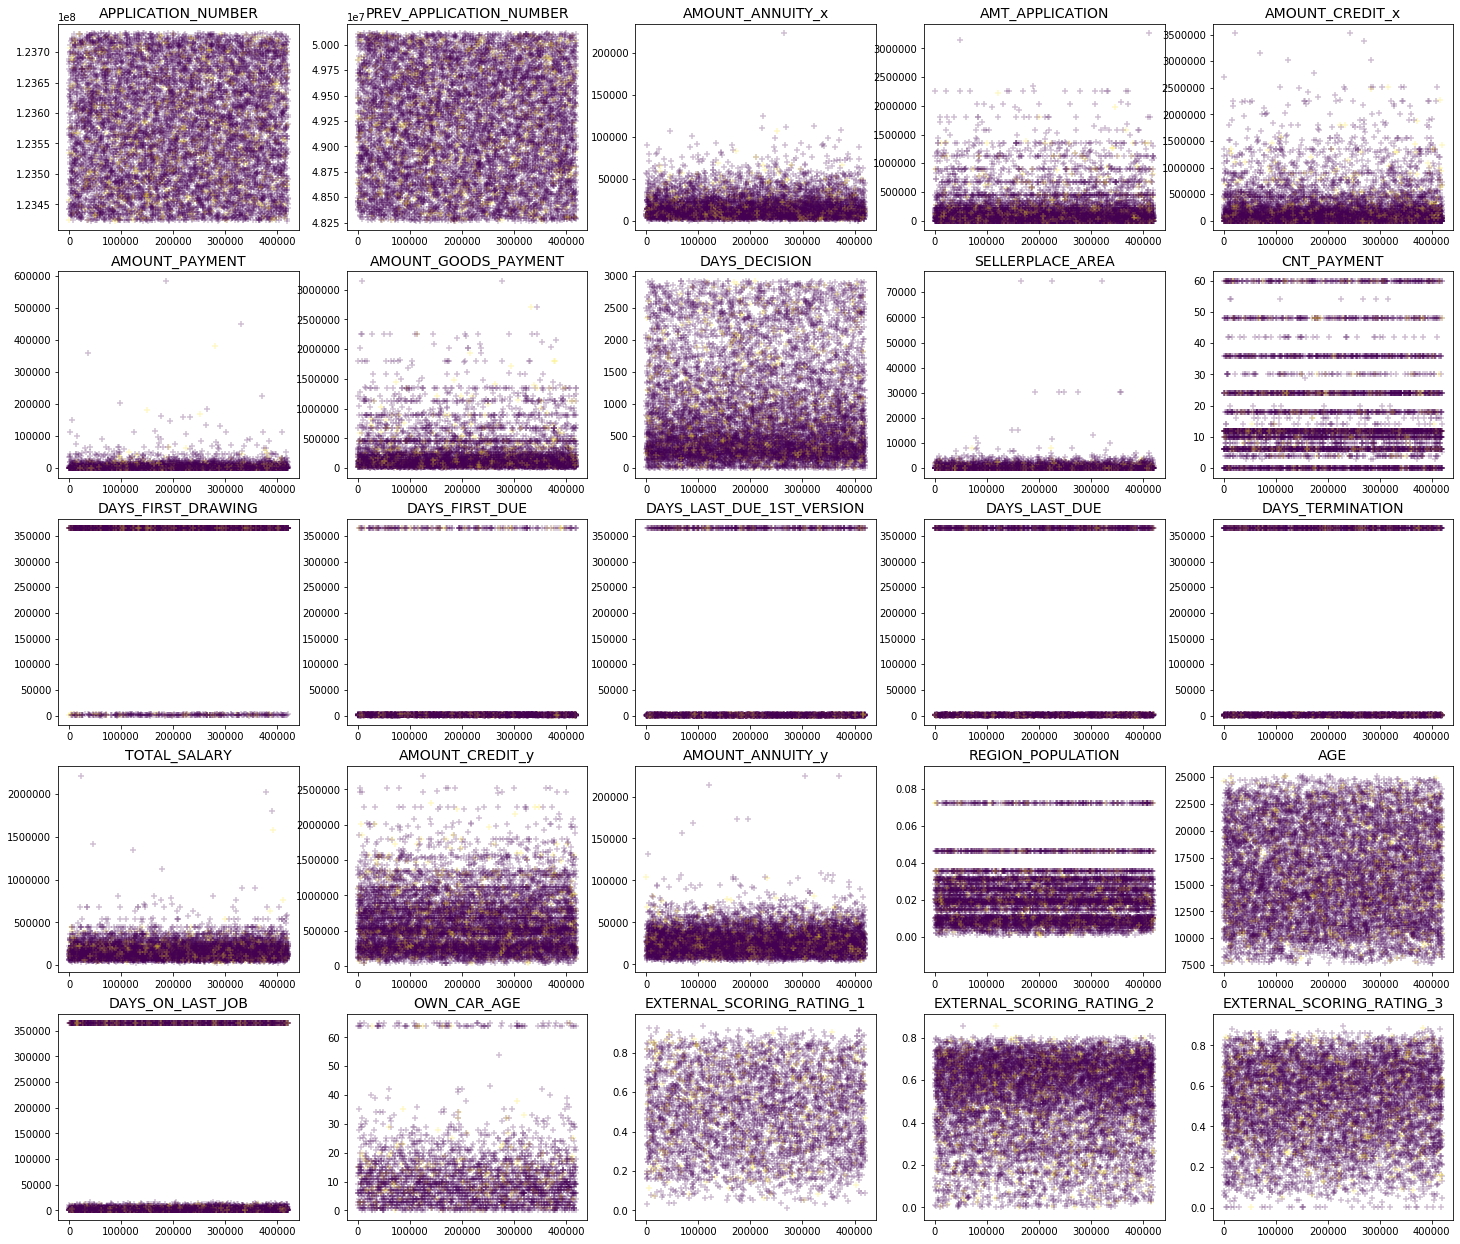

In [71]:
fig, axes = plt.subplots(5, 5, figsize=(25, 22))

for num, feature in enumerate(continuous_feature, start=1):
    plt.subplot(5, 5, num)
    plt.title(f"{feature}", size=14)
    plt.scatter(
        train[feature].sample(10000).index,
        train[feature].sample(10000),
        c=train["TARGET"].sample(10000),
        cmap="viridis",
        alpha=0.25,
        marker="+")

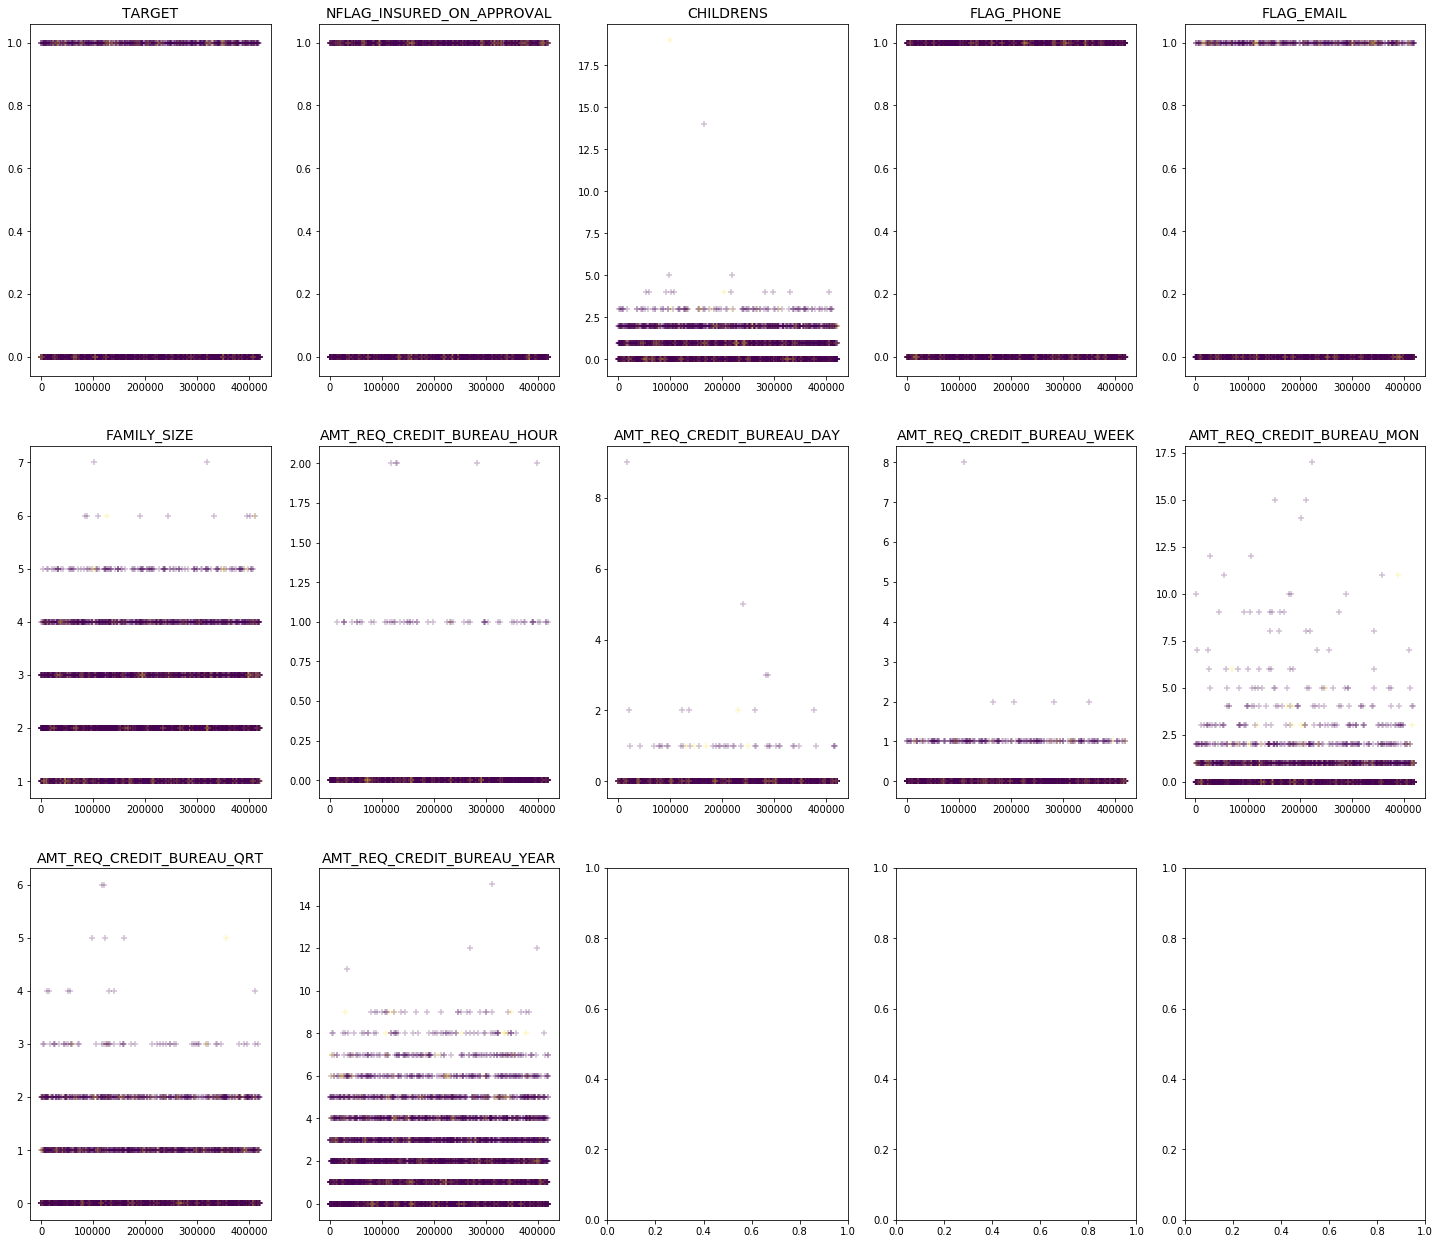

In [77]:
fig, axes = plt.subplots(3, 5, figsize=(25, 22))

for num, feature in enumerate(discrete_feature, start=1):
    plt.subplot(3, 5, num)
    plt.title(f"{feature}", size=14)
    plt.scatter(
        train[feature].sample(10000).index,
        train[feature].sample(10000),
        c=train["TARGET"].sample(10000),
        cmap="viridis",
        alpha=0.25,
        marker="+")

TypeError: nan is not a string

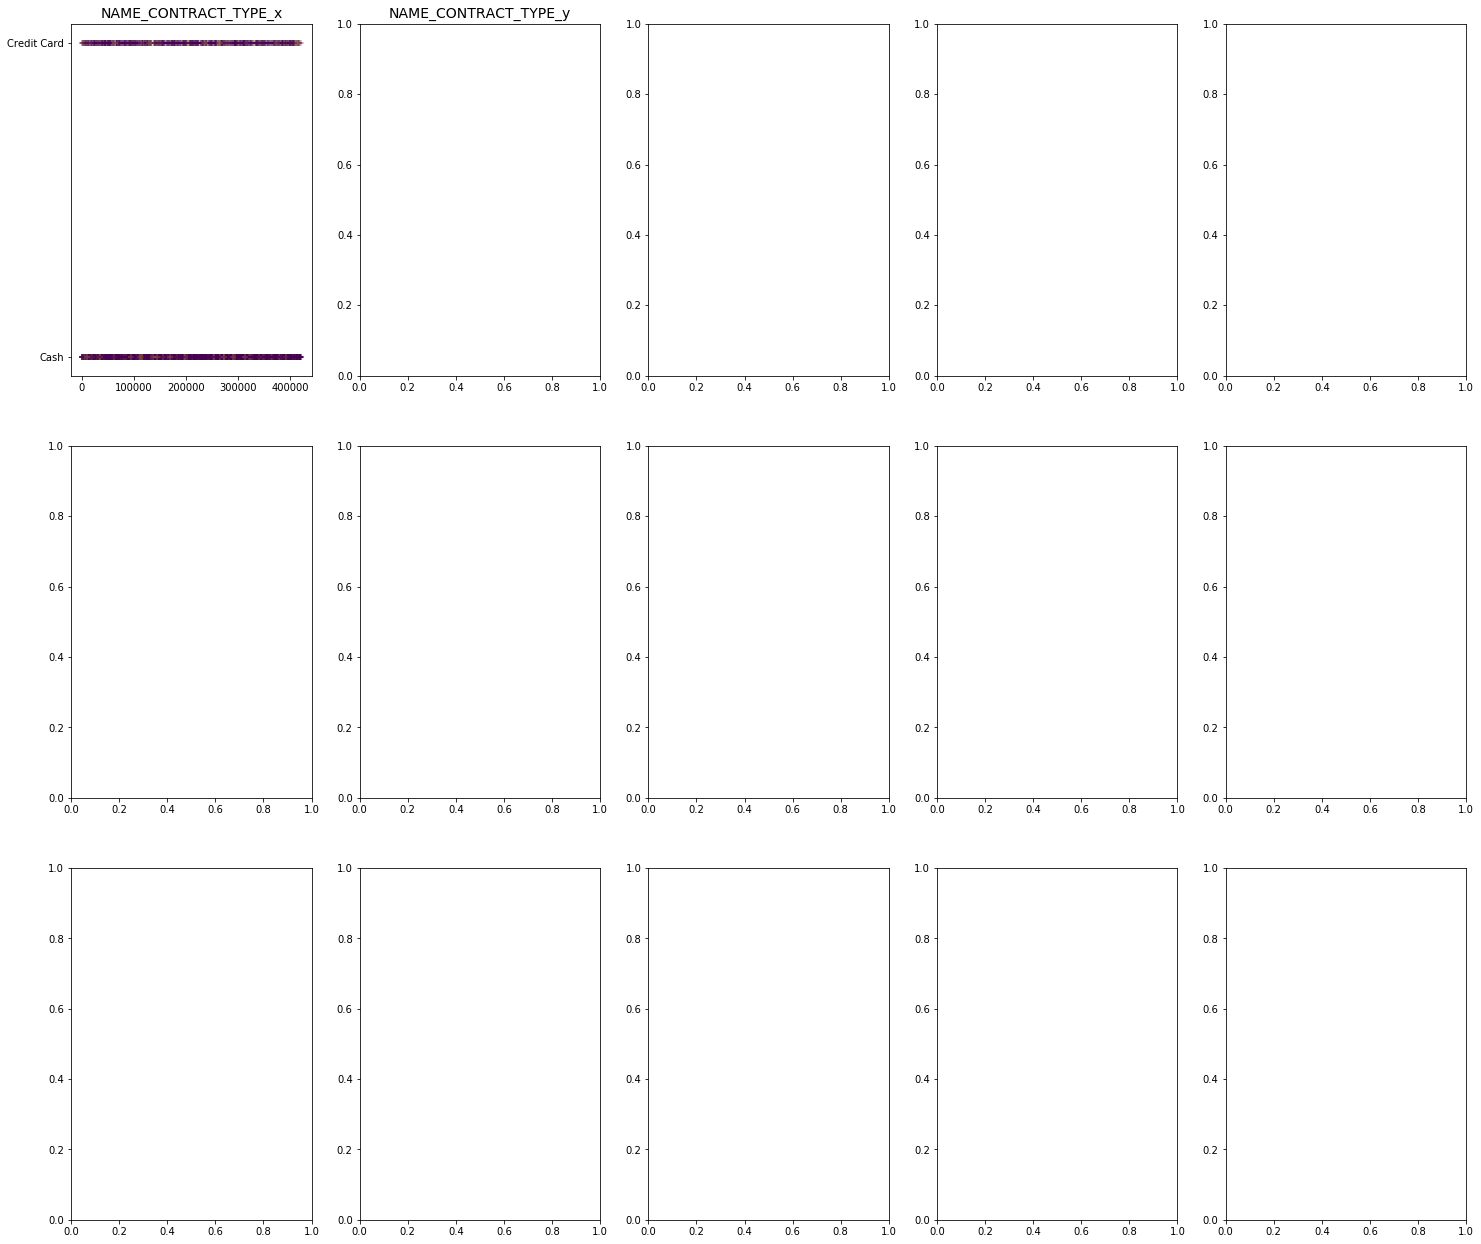

In [78]:
fig, axes = plt.subplots(3, 5, figsize=(25, 22))

for num, feature in enumerate(categorical_features, start=1):
    plt.subplot(3, 5, num)
    plt.title(f"{feature}", size=14)
    plt.scatter(
        train[feature].sample(10000).index,
        train[feature].sample(10000),
        c=train["TARGET"].sample(10000),
        cmap="viridis",
        alpha=0.25,
        marker="+")